# S2RA-2023_write_ETBF_zarr
## LARGEMEM local cluster compute approach
## TRY without `rechunker` as runs are hanging for some reason?

**Date:** <br>
3 - 27 April 2023 <br>
**Background:** <br>
Issue - https://github.com/Thomas-Moore-Creative/NCI-ACCESS-S2-ARD/issues/8 <br>
**Author(s):**<br>
Thomas Moore<br>

## We are using NCI ARE

In [1]:
Author1 = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

In [2]:
import xarray as xr
import numpy as np
import xesmf as xe
import scipy
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import os
import re
import cartopy.crs as ccrs
import proplot as pplt
from rechunker import rechunk
%config Completer.use_jedi = False

## import helper

In [3]:
import importlib.util
spec = importlib.util.spec_from_file_location("helper", "/g/data/v14/tm4888/code/helper-py/helper_tools.py")
helper = importlib.util.module_from_spec(spec)
spec.loader.exec_module(helper)

# ARE cluster

# or start a local cluster

In [4]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

In [5]:
print(client)

<Client: 'tcp://127.0.0.1:46223' processes=7 threads=28, memory=251.20 GiB>


# do we still need this preprocess functions or did BOM / NCI address the issue raised?

# Appears the "2015 fix" is no longer needed?
### define preprocess drop function
##### this unfortunately removes useful information like areau that's missing from 2015 files

In [6]:
def fix_SSHname(ds):
    if 'ssh' in ds.data_vars:
        ds = ds.rename({'ssh':'ssh_corrected'})
    return ds

# "T-grid" variables // SST, SSS, SSH, MLD1-2,d20,HC300,td

### load the whole timeseries using `fix_SSHname` preproccessor where needed

In [7]:
%%time
ds_SST = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/sst/mo_sst_*.nc',parallel=True)

CPU times: user 5.49 s, sys: 1.33 s, total: 6.83 s
Wall time: 18.3 s


In [8]:
%%time
ds_SSS = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/sss/mo_sss_*.nc',parallel=True)

CPU times: user 4.07 s, sys: 633 ms, total: 4.7 s
Wall time: 11 s


In [9]:
%%time
ds_SSH = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/ssh_corrected/mo_ssh_corrected_*.nc',parallel=True,preprocess=fix_SSHname)

CPU times: user 4.11 s, sys: 641 ms, total: 4.75 s
Wall time: 10.2 s


In [10]:
%%time
ds_mld1 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/mld1/mo_mld1_*.nc',parallel=True)

CPU times: user 3.89 s, sys: 623 ms, total: 4.51 s
Wall time: 9.77 s


In [11]:
%%time
ds_mld2 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/mld2/mo_mld2_*.nc',parallel=True)

CPU times: user 4.05 s, sys: 629 ms, total: 4.68 s
Wall time: 9.77 s


In [12]:
%%time
ds_D20 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/d20/mo_d20_*.nc',parallel=True)

CPU times: user 3.88 s, sys: 646 ms, total: 4.52 s
Wall time: 9.81 s


In [13]:
%%time
ds_hc300 = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/hc300/mo_hc300_*.nc',parallel=True)

CPU times: user 3.85 s, sys: 537 ms, total: 4.39 s
Wall time: 9.98 s


In [14]:
%%time
ds_td = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/td/mo_td_*.nc',parallel=True)

CPU times: user 4.12 s, sys: 570 ms, total: 4.69 s
Wall time: 9.84 s


In [15]:
%%time
ds_temp = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/temp/mo_temp_*.nc',parallel=True)

CPU times: user 4.12 s, sys: 567 ms, total: 4.69 s
Wall time: 11.5 s


In [16]:
ds_temp50 = ds_temp.sel(deptht=50,method='nearest').rename({'temp':'temp50'})
ds_temp100 = ds_temp.sel(deptht=100,method='nearest').rename({'temp':'temp100'})
ds_temp200 = ds_temp.sel(deptht=200,method='nearest').rename({'temp':'temp200'})
ds_temp500 = ds_temp.sel(deptht=500,method='nearest').rename({'temp':'temp500'})

## remove SSH as new data has QC issues

In [17]:
#some model variables need a squeeze, some don't
ds_ACCESS_S2_RA_ocean = xr.merge([ds_temp50.drop('deptht'),
                                  ds_temp100.drop('deptht'),
                                  ds_temp200.drop('deptht'),
                                  ds_temp500.drop('deptht'),
                                  ds_SST.squeeze(),
                                  ds_SSS.squeeze(),
                                  ds_mld1,
                                  ds_mld2,
                                  ds_D20,
                                  ds_hc300,
                                  ds_td
                                 ],compat='override')
ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.drop('time_counter_bnds')
ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.drop('deptht')
ds_ACCESS_S2_RA_ocean

<xarray.Dataset>
Dimensions:        (time_counter: 507, y: 1021, x: 1442, ndepth_bounds: 2, ncorners: 4)
Coordinates:
    nav_lat        (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 1981-01-16T12:00:00 ... 2023...
Dimensions without coordinates: y, x, ndepth_bounds, ncorners
Data variables: (12/15)
    areat          (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    deptht_bounds  (time_counter, ndepth_bounds) float32 dask.array<chunksize=(12, 2), meta=np.ndarray>
    latt_bounds    (time_counter, y, x, ncorners) float32 dask.array<chunksize=(12, 1021, 1442, 4), meta=np.ndarray>
    lont_bounds    (time_counter, y, x, ncorners) float32 dask.array<chunksize=(12, 1021, 1442, 4), meta=np.ndarray>
    temp50         (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    temp100        (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    ...             ...
    sss            (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    mld1           (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    mld2           (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    d20            (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    hc300          (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    td             (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    12/09/2018 08:38:02 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr  2 18:06:48 2019: ncatted -a history,global,d,, mo_...

### SSH has problems // ValueError: cannot reindex or align along dimension 'time_counter' because the index has duplicate values

In [18]:
ds_SSH

<xarray.Dataset>
Dimensions:            (time_counter: 507, y: 1021, x: 1442, ncorners: 4, tbnds: 2)
Coordinates:
    nav_lat            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    nav_lon            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time_counter       (time_counter) datetime64[ns] 1981-01-16T12:00:00 ... ...
Dimensions without coordinates: y, x, ncorners, tbnds
Data variables:
    areat              (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    latt_bounds        (time_counter, y, x, ncorners) float32 dask.array<chunksize=(12, 1021, 1442, 4), meta=np.ndarray>
    lont_bounds        (time_counter, y, x, ncorners) float32 dask.array<chunksize=(12, 1021, 1442, 4), meta=np.ndarray>
    ssh_corrected      (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    time_counter_bnds  (time_counter, tbnds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    12/09/2018 08:38:02 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr  2 17:05:20 2019: ncatted -a history,global,d,, mo_...
    correction:   Correction to the file so that the weighed average SSH is z...

In [19]:
ds_SSH.time_counter[503:505]

<xarray.DataArray 'time_counter' (time_counter: 2)>
array(['2022-12-01T12:00:00.000000000', '2022-12-01T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2022-12-01T12:00:00 2022-12-0...
Attributes:
    axis:           T
    standard_name:  time
    title:          Time
    long_name:      Time axis
    time_origin:     1981-JAN-01 00:00:00
    bounds:         time_counter_bnds
    cell_methods:   time_counter: mean

## NO LONGER REQUIRED GIVEN FIX TO 2015 DATA FILES // add back in key metadata

# rename time and lat/lon

In [20]:
ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.rename({'time_counter':'time'})

In [21]:
ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
ds_ACCESS_S2_RA_ocean

<xarray.Dataset>
Dimensions:        (time: 507, y: 1021, x: 1442, ndepth_bounds: 2, ncorners: 4)
Coordinates:
    lat            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    lon            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time           (time) datetime64[ns] 1981-01-16T12:00:00 ... 2023-03-01T1...
Dimensions without coordinates: y, x, ndepth_bounds, ncorners
Data variables: (12/15)
    areat          (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    deptht_bounds  (time, ndepth_bounds) float32 dask.array<chunksize=(12, 2), meta=np.ndarray>
    latt_bounds    (time, y, x, ncorners) float32 dask.array<chunksize=(12, 1021, 1442, 4), meta=np.ndarray>
    lont_bounds    (time, y, x, ncorners) float32 dask.array<chunksize=(12, 1021, 1442, 4), meta=np.ndarray>
    temp50         (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    temp100        (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    ...             ...
    sss            (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    mld1           (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    mld2           (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    d20            (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    hc300          (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    td             (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    12/09/2018 08:38:02 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr  2 18:06:48 2019: ncatted -a history,global,d,, mo_...

In [22]:
ds_ACCESS_S2_RA_ocean.nbytes/1e9

59.727544288

# Deal with inconsistant and crazy "times" across collection of S2 netcdf files

In [23]:
S2_time_df = ds_ACCESS_S2_RA_ocean.time.to_dataframe()
truncated_S2_time = pd.to_datetime(S2_time_df.time).dt.date
year_month_day_strings = [ string[:-2]+'15' for string in truncated_S2_time.astype(str) ]
new_S2_datetime = pd.to_datetime(year_month_day_strings)
#replace time with cleaned version
ds_ACCESS_S2_RA_ocean['time'] = new_S2_datetime

# SAVE ocean tgrid zarr file

### rechunk to make chunks consistent

In [28]:
ds_ACCESS_S2_RA_ocean = ds_ACCESS_S2_RA_ocean.chunk({"x": 1442, "y": 1021,"time":12})

In [24]:
ds_ACCESS_S2_RA_ocean

<xarray.Dataset>
Dimensions:        (time: 507, y: 1021, x: 1442, ndepth_bounds: 2, ncorners: 4)
Coordinates:
    lat            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    lon            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time           (time) datetime64[ns] 1981-01-15 1981-02-15 ... 2023-03-15
Dimensions without coordinates: y, x, ndepth_bounds, ncorners
Data variables: (12/15)
    areat          (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    deptht_bounds  (time, ndepth_bounds) float32 dask.array<chunksize=(12, 2), meta=np.ndarray>
    latt_bounds    (time, y, x, ncorners) float32 dask.array<chunksize=(12, 1021, 1442, 4), meta=np.ndarray>
    lont_bounds    (time, y, x, ncorners) float32 dask.array<chunksize=(12, 1021, 1442, 4), meta=np.ndarray>
    temp50         (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    temp100        (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    ...             ...
    sss            (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    mld1           (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    mld2           (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    d20            (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    hc300          (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    td             (time, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    12/09/2018 08:38:02 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr  2 18:06:48 2019: ncatted -a history,global,d,, mo_...

In [26]:
%%time
ds_ACCESS_S2_RA_ocean.to_zarr(store = '/g/data/xv83/users/tm4888/data/ACCESS-S2/2023_accessS2_update/accessS2.RA.ocean.nativeTgrid.zarr',consolidated=True)

distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


CPU times: user 1min 32s, sys: 7.37 s, total: 1min 39s
Wall time: 7min 32s


# Check if zarr collections exist in `/g/data/v14/tm4888/data/ACCESS-S2/` and skip above
# $\Downarrow$

In [6]:
ds_ACCESS_S2_RA_ocean_nativeTgrid = xr.open_zarr('/g/data/xv83/users/tm4888/data/ACCESS-S2/2023_accessS2_update/accessS2.RA.ocean.nativeTgrid.zarr',consolidated=True)

CPU times: user 1.34 s, sys: 777 ms, total: 2.12 s
Wall time: 7.91 s


Text(0, 0.5, 'y')

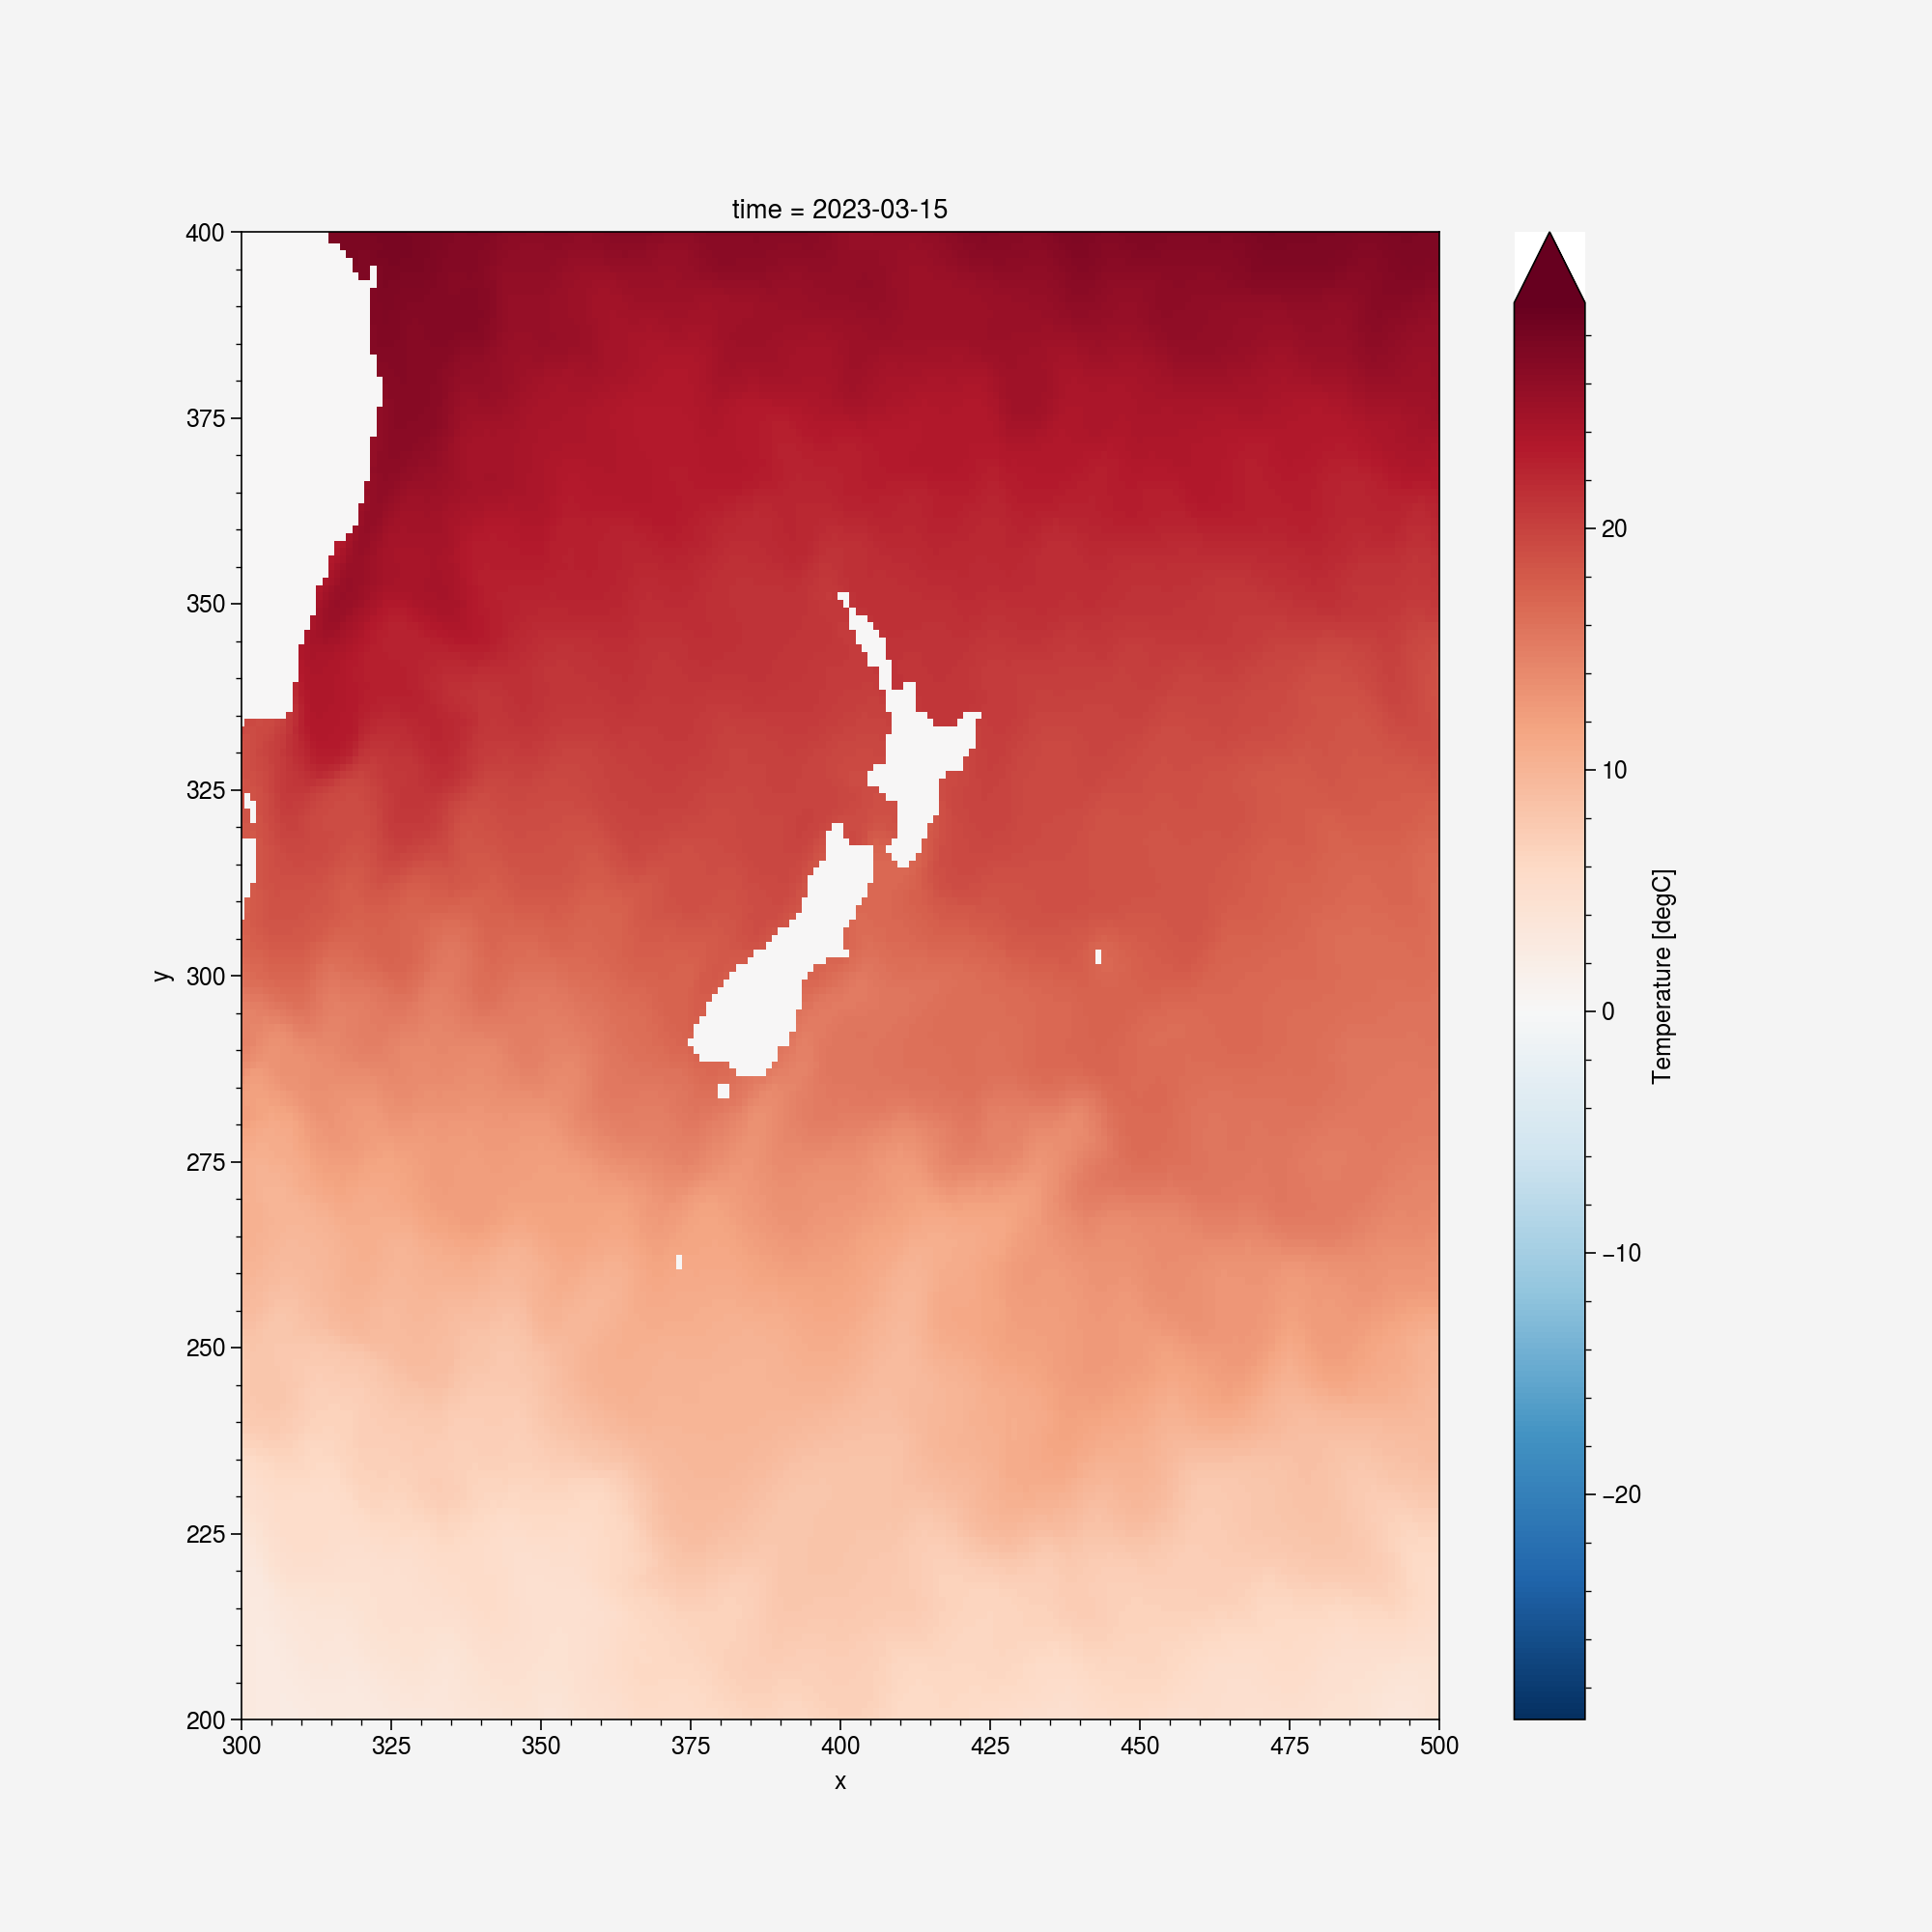

In [7]:
%%time
ds_ACCESS_S2_RA_ocean_nativeTgrid.sst.isel(time=506).plot(robust=True)
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.ylim([200, 400])
plt.xlim([300, 500])
plt.xlabel('x')
plt.ylabel('y')
#plt.title('sst snapshot')

CPU times: user 5.2 s, sys: 1.42 s, total: 6.62 s
Wall time: 32 s


Text(0.5, 1.0, 'sst - time mean')

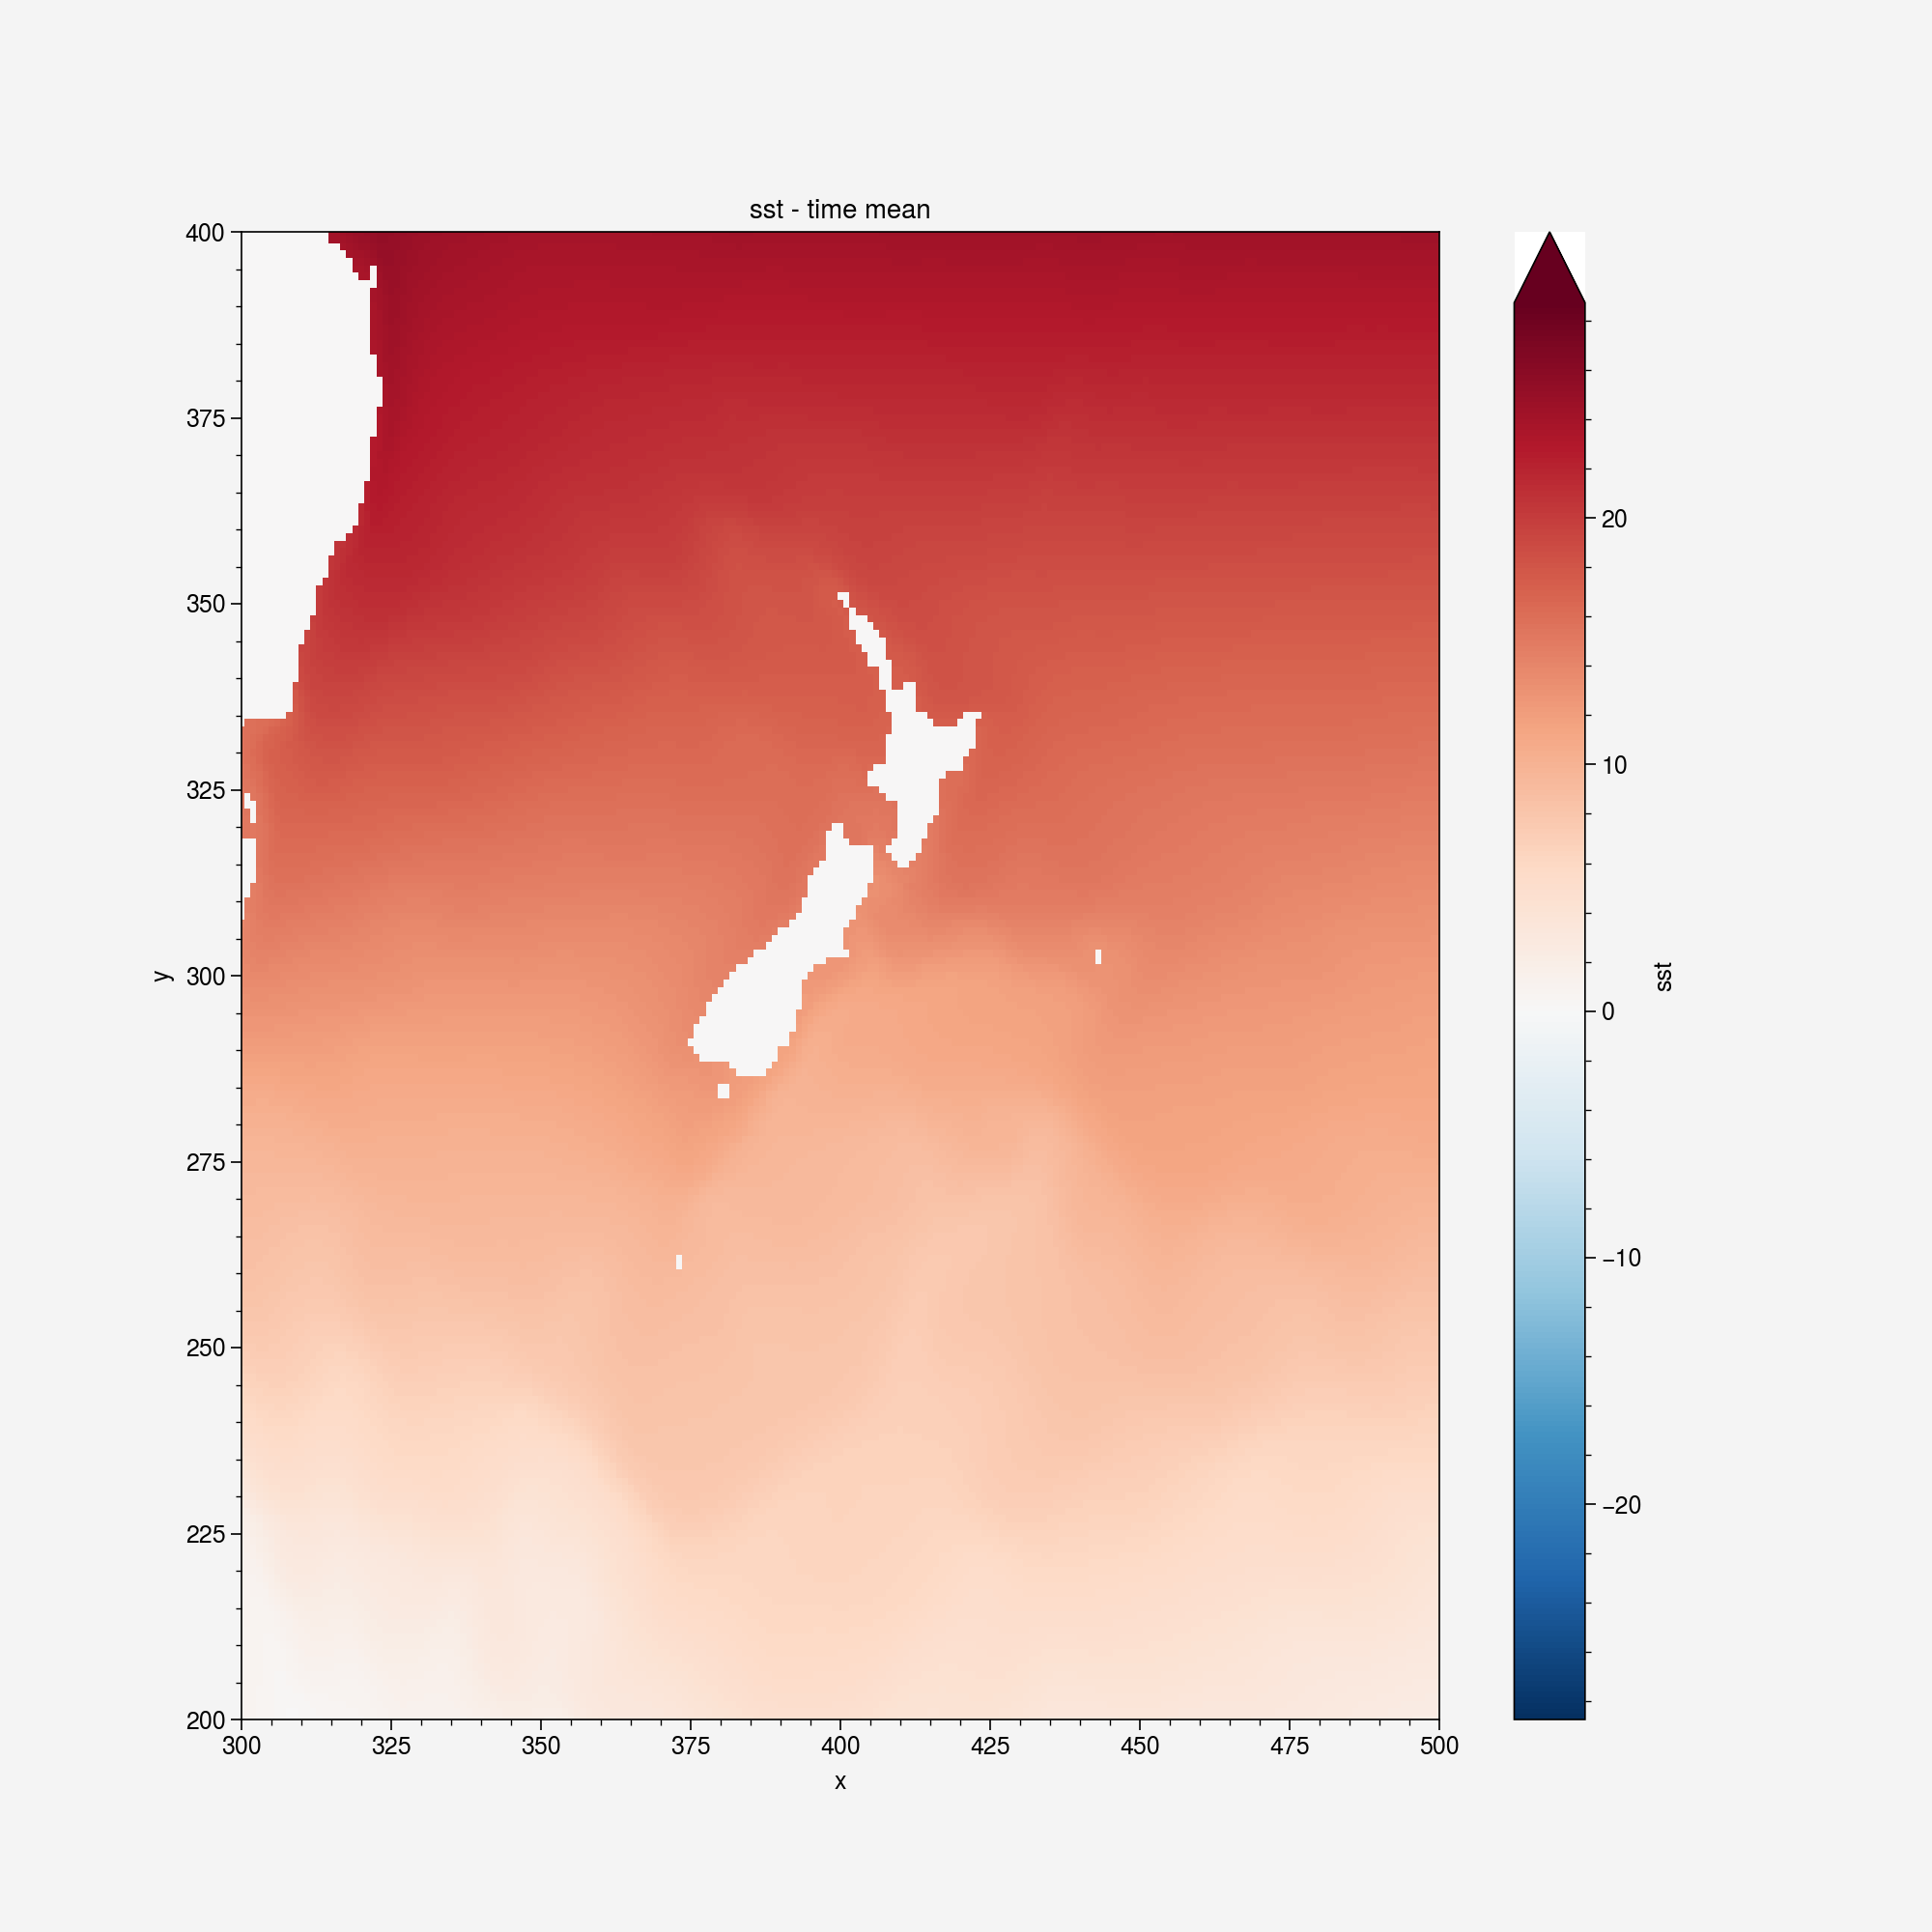

In [7]:
%%time
ds_ACCESS_S2_RA_ocean_nativeTgrid.sst.mean('time').plot(robust=True)
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.ylim([200, 400])
plt.xlim([300, 500])
plt.xlabel('x')
plt.ylabel('y')
plt.title('sst - time mean')

# file size

In [7]:
ds_ACCESS_S2_RA_ocean_nativeTgrid.nbytes/1e9

59.727544288

# U & V

# Check if zarr collections exist in `/g/data/v14/tm4888/data/ACCESS-S2/` and skip arrows if you can
# $\Downarrow$

# ACCESS-S2 ocean reanalysis (RA) 1981 - 2018

# load U & V S2_RA - pre-process function no longer needed

In [8]:
%%time
# define preprocess drop function - this unfortunately removes useful information like areau that's missing from 2015 files
#def drop_not_in_2015(ds):
#    if 'latu_bounds' in ds.data_vars:
#        ds = ds.drop(['latu_bounds'])
#    if 'lonu_bounds' in ds.data_vars:
#        ds = ds.drop(['lonu_bounds'])
#    if 'latv_bounds' in ds.data_vars:
#        ds = ds.drop(['latv_bounds'])
#    if 'lonv_bounds' in ds.data_vars:
#        ds = ds.drop(['lonv_bounds'])
#    if 'depthu_bounds' in ds.data_vars:
#        ds = ds.drop(['depthu_bounds'])
#    if 'areau' in ds.data_vars:
#        ds = ds.drop(['areau'])
#    if 'depthv_bounds' in ds.data_vars:
#        ds = ds.drop(['depthv_bounds'])
#    if 'areav' in ds.data_vars:
#        ds = ds.drop(['areav'])    
#    return ds
#ds_u = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/u/mo_u_*.nc',parallel=True,preprocess=drop_not_in_2015)
ds_u = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/u/mo_u_*.nc',parallel=True)
ds_u

CPU times: user 6.19 s, sys: 1.83 s, total: 8.02 s
Wall time: 25.8 s


<xarray.Dataset>
Dimensions:            (time_counter: 507, y: 1021, x: 1442, depthu: 75, ndepth_bounds: 2, ncorners: 4, tbnds: 2)
Coordinates:
  * depthu             (depthu) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
    nav_lat            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    nav_lon            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time_counter       (time_counter) datetime64[ns] 1981-01-16T12:00:00 ... ...
Dimensions without coordinates: y, x, ndepth_bounds, ncorners, tbnds
Data variables:
    areau              (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    depthu_bounds      (time_counter, depthu, ndepth_bounds) float32 dask.array<chunksize=(12, 75, 2), meta=np.ndarray>
    latu_bounds        (time_counter, y, x, ncorners) float32 dask.array<chunksize=(12, 1021, 1442, 4), meta=np.ndarray>
    lonu_bounds        (time_counter, y, x, ncorners) float32 dask.array<chunksize=(12, 1021, 1442, 4), meta=np.ndarray>
    time_counter_bnds  (time_counter, tbnds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    u                  (time_counter, depthu, y, x) float32 dask.array<chunksize=(12, 75, 1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    12/09/2018 08:37:54 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr  2 18:39:39 2019: ncatted -a history,global,d,, mo_...

In [9]:
%%time
# define preprocess drop function - this unfortunately removes useful information like areau that's missing from 2015 files
#def drop_not_in_2015(ds):
#    if 'latu_bounds' in ds.data_vars:
#        ds = ds.drop(['latu_bounds'])
#    if 'lonu_bounds' in ds.data_vars:
#        ds = ds.drop(['lonu_bounds'])
#    if 'latv_bounds' in ds.data_vars:
#        ds = ds.drop(['latv_bounds'])
#    if 'lonv_bounds' in ds.data_vars:
#        ds = ds.drop(['lonv_bounds'])
#    if 'depthu_bounds' in ds.data_vars:
#        ds = ds.drop(['depthu_bounds'])
#    if 'areau' in ds.data_vars:
#        ds = ds.drop(['areau'])
#    if 'depthv_bounds' in ds.data_vars:
#        ds = ds.drop(['depthv_bounds'])
#    if 'areav' in ds.data_vars:
#        ds = ds.drop(['areav'])    
#    return ds
#ds_v = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/v/mo_v_*.nc',parallel=True,preprocess=drop_not_in_2015)
ds_v = xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/v/mo_v_*.nc',parallel=True)
ds_v

CPU times: user 4.41 s, sys: 844 ms, total: 5.25 s
Wall time: 12.2 s


<xarray.Dataset>
Dimensions:            (time_counter: 507, y: 1021, x: 1442, depthv: 75, ndepth_bounds: 2, ncorners: 4, tbnds: 2)
Coordinates:
  * depthv             (depthv) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
    nav_lat            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    nav_lon            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * time_counter       (time_counter) datetime64[ns] 1981-01-16T12:00:00 ... ...
Dimensions without coordinates: y, x, ndepth_bounds, ncorners, tbnds
Data variables:
    areav              (time_counter, y, x) float32 dask.array<chunksize=(12, 1021, 1442), meta=np.ndarray>
    depthv_bounds      (time_counter, depthv, ndepth_bounds) float32 dask.array<chunksize=(12, 75, 2), meta=np.ndarray>
    latv_bounds        (time_counter, y, x, ncorners) float32 dask.array<chunksize=(12, 1021, 1442, 4), meta=np.ndarray>
    lonv_bounds        (time_counter, y, x, ncorners) float32 dask.array<chunksize=(12, 1021, 1442, 4), meta=np.ndarray>
    time_counter_bnds  (time_counter, tbnds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    v                  (time_counter, depthv, y, x) float32 dask.array<chunksize=(12, 75, 1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    12/09/2018 08:37:34 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr  2 18:08:10 2019: ncatted -a history,global,d,, mo_...

# Need to review why this is needed - but it seems to be if we want area* to not depend on time?

In [10]:
areau = (xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/u/mo_u_2016.nc',parallel=True)).areau.to_dataset()
areav = (xr.open_mfdataset('/g/data/ux62/access-s2/reanalysis/ocean/v/mo_v_2016.nc',parallel=True)).areav.to_dataset()

## drop time dependent areas that aren't needed

In [11]:
ds_u = ds_u.drop('areau')
ds_v = ds_v.drop('areav')

In [12]:
ds_u = xr.combine_by_coords([ds_u,areau])
ds_v = xr.combine_by_coords([ds_v,areav])

# Deal with the same depth coordinates given two different names & rename time

In [13]:
ds_u = ds_u.rename({'depthu':'depth','time_counter':'time'})
ds_v = ds_v.rename({'depthv':'depth','time_counter':'time'})

# rename lat/lon

In [14]:
ds_u = ds_u.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
ds_v = ds_v.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})

# Deal with inconsistant and crazy dates (use time from Tgrid zarr already corrected)

In [15]:
new_time = ds_ACCESS_S2_RA_ocean_nativeTgrid.time

In [16]:
ds_u['time'] = new_time
ds_v['time'] = new_time

In [17]:
ds_u

<xarray.Dataset>
Dimensions:            (y: 1021, x: 1442, depth: 75, time: 507, ndepth_bounds: 2, ncorners: 4, tbnds: 2)
Coordinates:
    lat                (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    lon                (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * depth              (depth) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
  * time               (time) datetime64[ns] 1981-01-15 ... 2023-03-15
Dimensions without coordinates: y, x, ndepth_bounds, ncorners, tbnds
Data variables:
    areau              (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    depthu_bounds      (time, depth, ndepth_bounds) float32 dask.array<chunksize=(12, 75, 2), meta=np.ndarray>
    latu_bounds        (time, y, x, ncorners) float32 dask.array<chunksize=(12, 1021, 1442, 4), meta=np.ndarray>
    lonu_bounds        (time, y, x, ncorners) float32 dask.array<chunksize=(12, 1021, 1442, 4), meta=np.ndarray>
    time_counter_bnds  (time, tbnds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    u                  (time, depth, y, x) float32 dask.array<chunksize=(12, 75, 1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    12/09/2018 08:37:54 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr  2 18:39:39 2019: ncatted -a history,global,d,, mo_...

# Double Check for bugged time stamps

In [18]:
u_time = ds_u.time.values
v_time = ds_v.time.values
ds_ACCESS_S2_RA_ocean_nativeTgrid_time = ds_ACCESS_S2_RA_ocean_nativeTgrid.time.values

In [19]:
compare_UV = (u_time == v_time)
np.where(compare_UV==False)

(array([], dtype=int64),)

In [20]:
u_time[236]

numpy.datetime64('2000-09-15T00:00:00.000000000')

In [21]:
v_time[236]

numpy.datetime64('2000-09-15T00:00:00.000000000')

In [22]:
ds_ACCESS_S2_RA_ocean_nativeTgrid_time[236]

numpy.datetime64('2000-09-15T00:00:00.000000000')

In [23]:
u_time[329]

numpy.datetime64('2008-06-15T00:00:00.000000000')

In [24]:
v_time[329]

numpy.datetime64('2008-06-15T00:00:00.000000000')

In [25]:
ds_ACCESS_S2_RA_ocean_nativeTgrid_time[329]

numpy.datetime64('2008-06-15T00:00:00.000000000')

# Checks out

# drop `time_counter_bounds` var

In [18]:
ds_u = ds_u.drop('time_counter_bnds')
ds_v = ds_v.drop('time_counter_bnds')

In [19]:
ds_u

<xarray.Dataset>
Dimensions:        (y: 1021, x: 1442, depth: 75, time: 507, ndepth_bounds: 2, ncorners: 4)
Coordinates:
    lat            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    lon            (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * depth          (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time           (time) datetime64[ns] 1981-01-15 1981-02-15 ... 2023-03-15
Dimensions without coordinates: y, x, ndepth_bounds, ncorners
Data variables:
    areau          (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    depthu_bounds  (time, depth, ndepth_bounds) float32 dask.array<chunksize=(12, 75, 2), meta=np.ndarray>
    latu_bounds    (time, y, x, ncorners) float32 dask.array<chunksize=(12, 1021, 1442, 4), meta=np.ndarray>
    lonu_bounds    (time, y, x, ncorners) float32 dask.array<chunksize=(12, 1021, 1442, 4), meta=np.ndarray>
    u              (time, depth, y, x) float32 dask.array<chunksize=(12, 75, 1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    12/09/2018 08:37:54 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr  2 18:39:39 2019: ncatted -a history,global,d,, mo_...

# write out native grid U & V zarr collections

In [20]:
ds_u = ds_u[['u','areau']]
# not sure this encoding reset is needed #
for var in ds_u.variables:
        ds_u[var].encoding = {}

In [21]:
ds_u

<xarray.Dataset>
Dimensions:  (time: 507, depth: 75, y: 1021, x: 1442)
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
  * depth    (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time     (time) datetime64[ns] 1981-01-15 1981-02-15 ... 2023-03-15
Dimensions without coordinates: y, x
Data variables:
    u        (time, depth, y, x) float32 dask.array<chunksize=(12, 75, 1021, 1442), meta=np.ndarray>
    areau    (y, x) float32 dask.array<chunksize=(1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    12/09/2018 08:37:54 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr  2 18:39:39 2019: ncatted -a history,global,d,, mo_...

In [24]:
ds_u.nbytes/1e9

223.95176394

# Can we write out zarr without rechunking? No: chunks are too big

In [31]:
%%time
ds_u.to_zarr(store = '/g/data/xv83/users/tm4888/data/ACCESS-S2/2023_accessS2_update/accessS2.RA.ocean.nativeUgrid.notchunked.zarr',consolidated=True)

ValueError: Codec does not support buffers of > 2147483647 bytes

## blindly try with using rechunker in the hopes that is the problem (when it's usually the solution!)

In [22]:
ds_u = ds_u.chunk({'time':507,'depth':1,'x':500,'y':500})

In [23]:
ds_u

<xarray.Dataset>
Dimensions:  (time: 507, depth: 75, y: 1021, x: 1442)
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
  * depth    (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time     (time) datetime64[ns] 1981-01-15 1981-02-15 ... 2023-03-15
Dimensions without coordinates: y, x
Data variables:
    u        (time, depth, y, x) float32 dask.array<chunksize=(507, 1, 500, 500), meta=np.ndarray>
    areau    (y, x) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    production:   An IPSL model
    TimeStamp:    12/09/2018 08:37:54 -0000
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    history:      Tue Apr  2 18:39:39 2019: ncatted -a history,global,d,, mo_...

# can I write this rechunked DS out to zarr w/o rechunker?

In [25]:
%%time
ds_u.to_zarr(store = '/g/data/xv83/users/tm4888/data/ACCESS-S2/2023_accessS2_update/accessS2.RA.ocean.nativeUgrid.zarr',consolidated=True)

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


KeyboardInterrupt: 

In [ ]:
%%time
target_chunks = {
        'u': {'time':507,'depth':1,'x':250,'y':250},
        'areau':{'x':1442,'y':1021},
        'time': None,
        'depth': None}

mem_max = '10GB'

target_store = '/g/data/xv83/users/tm4888/data/ACCESS-S2/2023_accessS2_update/.rechunker/group_rechunked.zarr'
temp_store = '/g/data/xv83/users/tm4888/data/ACCESS-S2/2023_accessS2_update/.rechunker/group_rechunked-tmp.zarr'
! rm -rf /g/data/xv83/users/tm4888/data/ACCESS-S2/2023_accessS2_update/.rechunker/*.zarr

array_plan = rechunk(ds_u, target_chunks, mem_max, target_store,temp_store=temp_store)
rechunked_result = array_plan.execute()
print('final chunking scheme:'+str(rechunked_result.u.chunks))
ds_u_rechunked = xr.open_zarr('/g/data/xv83/users/tm4888/data/ACCESS-S2/2023_accessS2_update/.rechunker/group_rechunked.zarr',
                             consolidated=False)
! rm -rf /g/data/xv83/users/tm4888/data/ACCESS-S2/2023_accessS2_update/accessS2.RA.ocean.u.nativeUgrid.zarr
ds_u_rechunked.to_zarr(store = '/g/data/xv83/users/tm4888/data/ACCESS-S2/2023_accessS2_update/accessS2.RA.ocean.u.nativeUgrid.zarr',
                                         consolidated=True)

In [31]:
ds_v = ds_v[['v','areav']]
# not sure this encoding reset is needed #
for var in ds_v.variables:
        ds_v[var].encoding = {}

In [33]:
%%time
target_chunks = {
        'v': {'time':507,'depth':1,'x':250,'y':250},
        'areav':{'x':1442,'y':1021},
        'time': None,
        'depth': None}

mem_max = '10GB'

target_store = '/g/data/xv83/users/tm4888/data/ACCESS-S2/2023_accessS2_update/.rechunker/group_rechunked.zarr'
temp_store = '/g/data/xv83/users/tm4888/data/ACCESS-S2/2023_accessS2_update/.rechunker/group_rechunked-tmp.zarr'
! rm -rf /g/data/xv83/users/tm4888/data/ACCESS-S2/2023_accessS2_update/.rechunker/*.zarr

array_plan = rechunk(ds_v, target_chunks, mem_max, target_store,temp_store=temp_store)
rechunked_result = array_plan.execute()
print('final chunking scheme:'+str(rechunked_result.v.chunks))
ds_v_rechunked = xr.open_zarr('/g/data/xv83/users/tm4888/data/ACCESS-S2/2023_accessS2_update/.rechunker/group_rechunked.zarr',
                             consolidated=False)
! rm -rf /g/data/xv83/users/tm4888/data/ACCESS-S2/2023_accessS2_update/accessS2.RA.ocean.v.nativeVgrid.zarr
ds_v_rechunked.to_zarr(store = '/g/data/xv83/users/tm4888/data/ACCESS-S2/2023_accessS2_update/accessS2.RA.ocean.v.nativeVgrid.zarr',
                                         consolidated=True)

final chunking scheme:(492, 1, 250, 250)
CPU times: user 1min 31s, sys: 9.28 s, total: 1min 41s
Wall time: 7min 31s


# $\Downarrow$
# CAN SKIP TO THIS STEP IF U & V `ZARR` FILES ARE WRITTEN AND AVAILABLE
hard part for u & v done above

In [35]:
u = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.u.nativeUgrid.zarr',consolidated=True)
v = xr.open_zarr('/g/data/v14/tm4888/data/ACCESS-S2/accessS2.RA.ocean.v.nativeVgrid.zarr',consolidated=True)

# $ The\ End$

# Break glass in case of emergency
# $\Downarrow$

In [30]:
client.restart()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37799,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: 29 minutes ago,Total memory: 0 B


distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing


In [26]:
client.shutdown()

KeyboardInterrupt: 

distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing


In [32]:
client.restart()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39265,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: 1 hour ago,Total memory: 0 B
